### Imports

In [22]:
import faiss
import numpy as np
import pandas as pd
import re
import pickle
from scipy.stats import entropy
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from scipy.spatial.distance import pdist, squareform
from time import time
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer('all-distilroberta-v1')
#model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Utils

In [2]:
def preprocess_genre(genre_str: str) -> list[str]:
    """
    Preprocess the genre string by splitting it and removing leading/trailing whitespaces.
    param genre_str: The genre string to preprocess
    """
    if pd.isna(genre_str):
        return []
    return [genre.strip() for genre in genre_str.split(',')]


def preprocess_description(description: str) -> str:
    """
    Preprocess the description.
    param description: The description to preprocess
    """
    if pd.isna(description):
        return ''
    words = re.findall(r'\b\w+\b', description.lower())
    words = [word.strip() for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)


def preprocess_data(data_path: str) -> pd.DataFrame:
    # Loads the csv file into a DataFrame
    imdb_movies_data = pd.read_csv(data_path)

    # Remove rows with missing values in the 'description' and 'genre' columns
    imdb_movies_data.dropna(subset=['description'], inplace=True)
    imdb_movies_data.dropna(subset=['genre'], inplace=True)

    imdb_movies_data['genre'] = imdb_movies_data['genre'].apply(preprocess_genre)

    # Number of genres per movie
    imdb_movies_data['num_genres'] = imdb_movies_data['genre'].apply(len)

    # Preprocess the description
    imdb_movies_data['description_processed'] = imdb_movies_data['description'].apply(preprocess_description)

    # keep only the columns we need
    imdb_movies_data = imdb_movies_data[['index', 'description_processed', 'genre']]

    return imdb_movies_data

### Running Code

In [5]:
df = preprocess_data('/home/student/idan/DataAnalysisAndVisualizationProject/dataanalysisvisualizationfiles/data/IMDb movies.csv')

#### Comparing Active Learning Methods

In [6]:
df = df[df['genre'].apply(lambda x: len(x) == 1)].reset_index(drop=True)
df['genre'] = df['genre'].apply(lambda x: x[0])
label_encoder = LabelEncoder()
df['genre'] = label_encoder.fit_transform(df['genre'])
y = df['genre']

In [23]:
descriptions = df['description_processed'].tolist()
X = model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/762 [00:00<?, ?it/s]

Batches: 100%|██████████| 762/762 [00:37<00:00, 20.14it/s]


In [28]:
iterations = 20
sample_size = 1000
np.random.seed(42)

In [24]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_train, y_pool, y_train = train_test_split(X_train_full, y_train_full, test_size=0.00255, random_state=42)

In [25]:
#clf = MultiOutputClassifier(RandomForestClassifier())
clf = SGDClassifier(loss='log_loss', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.5083145144734141


In [26]:
hamming_loss(y_test, y_pred)

0.4916854855265859

##### Test with Random for Single Label Subset

In [29]:
accuracy_scores = []
hamming_scores = []
f1_scores = []
for iteration in range(iterations):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    hamming_scores.append(hamming_loss(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy_score(y_test, y_pred):.4f}, Hamming Loss = {hamming_loss(y_test, y_pred)}, F1 = {f1_score(y_test, y_pred, average='weighted')} ")
    sample_size = min(sample_size, len(X_pool))
    selected_indices = np.random.choice(len(X_pool), size=sample_size, replace=False)
    X_sample = X_pool[selected_indices]
    try:
        y_sample = y_pool[selected_indices]
    except:
      y_sample = y_pool.iloc[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.concatenate([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
    if len(X_pool) == 0 or len(X_pool) < sample_size or len(X_train) >= 60000:
        break
print(classification_report(y_test, y_pred))

Iteration 1: Accuracy = 0.5083, Hamming Loss = 0.4916854855265859, F1 = 0.45769996206591407 
Iteration 2: Accuracy = 0.5830, Hamming Loss = 0.41695750359269146, F1 = 0.5591330031904088 
Iteration 3: Accuracy = 0.6134, Hamming Loss = 0.38657359885033876, F1 = 0.5830007399065016 
Iteration 4: Accuracy = 0.6136, Hamming Loss = 0.3863683021966742, F1 = 0.5804117599365624 
Iteration 5: Accuracy = 0.6227, Hamming Loss = 0.37733524943543423, F1 = 0.5852151627407362 
Iteration 6: Accuracy = 0.6184, Hamming Loss = 0.38164647916238964, F1 = 0.577186563870043 
Iteration 7: Accuracy = 0.6274, Hamming Loss = 0.37261342640114964, F1 = 0.5892993934048452 
Iteration 8: Accuracy = 0.6253, Hamming Loss = 0.37466639293779513, F1 = 0.584455163584273 
Iteration 9: Accuracy = 0.6311, Hamming Loss = 0.3689180866351878, F1 = 0.5978813743293241 
Iteration 10: Accuracy = 0.6317, Hamming Loss = 0.3683021966741942, F1 = 0.5946120143588993 
Iteration 11: Accuracy = 0.6278, Hamming Loss = 0.3722028330938206, F1 = 0

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

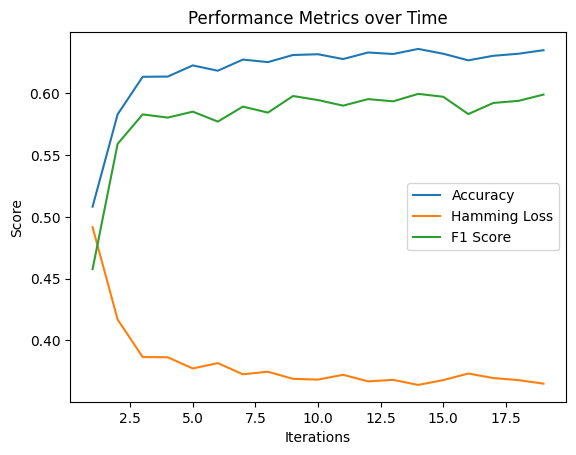

In [30]:
import matplotlib.pyplot as plt
iterations = range(1, len(accuracy_scores) + 1)

plt.plot(iterations, accuracy_scores, label='Accuracy')
plt.plot(iterations, hamming_scores, label='Hamming Loss')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()

In [31]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_train, y_pool, y_train = train_test_split(X_train_full, y_train_full, test_size=0.00255, random_state=42)
sample_size = 1000

accuracy_scores = []
hamming_scores = []
f1_scores = []
for iteration in range(20):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    hamming_scores.append(hamming_loss(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy_score(y_test, y_pred):.4f}, Hamming Loss = {hamming_loss(y_test, y_pred)}, F1 = {f1_score(y_test, y_pred, average='weighted')} ")
    sample_size = min(sample_size, len(X_pool))

    probs = clf.predict_proba(X_pool)
    entropies = entropy(probs, axis=1)
    selected_indices = np.argsort(entropies)[-sample_size:]
    X_sample = X_pool[selected_indices]
    try:
        y_sample = y_pool[selected_indices]
    except:
      y_sample = y_pool.iloc[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.concatenate([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
    if len(X_pool) == 0 or len(X_pool) < sample_size or len(X_train) >= 60000:
        break
print(classification_report(y_test, y_pred))

Iteration 1: Accuracy = 0.5083, Hamming Loss = 0.4916854855265859, F1 = 0.45769996206591407 


Iteration 2: Accuracy = 0.5939, Hamming Loss = 0.40607678094847055, F1 = 0.5636207637219843 
Iteration 3: Accuracy = 0.6161, Hamming Loss = 0.38390474235269967, F1 = 0.5843951582420194 
Iteration 4: Accuracy = 0.6251, Hamming Loss = 0.37487168959145967, F1 = 0.5926655714384199 
Iteration 5: Accuracy = 0.6259, Hamming Loss = 0.3740505029768015, F1 = 0.5917657315119224 
Iteration 6: Accuracy = 0.6276, Hamming Loss = 0.3724081297474851, F1 = 0.5958661796908283 
Iteration 7: Accuracy = 0.6305, Hamming Loss = 0.3695339765961815, F1 = 0.5946600796613765 
Iteration 8: Accuracy = 0.6290, Hamming Loss = 0.3709710531718333, F1 = 0.5901767918942616 
Iteration 9: Accuracy = 0.6317, Hamming Loss = 0.3683021966741942, F1 = 0.5971322203203897 
Iteration 10: Accuracy = 0.6346, Hamming Loss = 0.3654280435228906, F1 = 0.6030773710357769 
Iteration 11: Accuracy = 0.6323, Hamming Loss = 0.3676863067132006, F1 = 0.5950423086629125 
Iteration 12: Accuracy = 0.6348, Hamming Loss = 0.365222746869226, F1 = 0.6

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

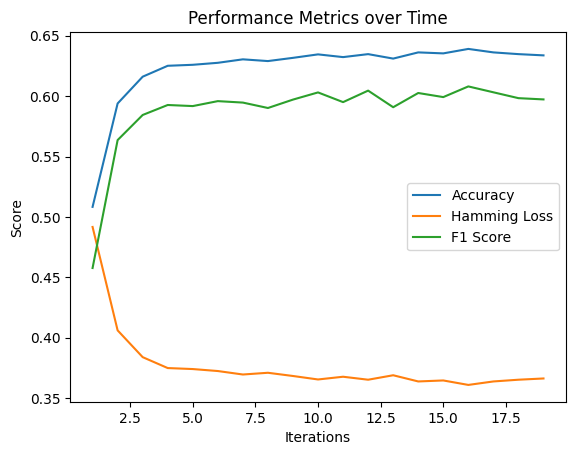

In [32]:
iterations = range(1, len(accuracy_scores) + 1)

plt.plot(iterations, accuracy_scores, label='Accuracy')
plt.plot(iterations, hamming_scores, label='Hamming Loss')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()

In [33]:
def margin_sampling(probs):
    sorted_probs = np.sort(probs, axis=1)  # Sort the probabilities for each sample
    margins = sorted_probs[:, -1] - sorted_probs[:, -2]  # Difference between the largest and second largest
    return margins

In [34]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_train, y_pool, y_train = train_test_split(X_train_full, y_train_full, test_size=0.00255, random_state=42)
sample_size = 1000
accuracy_scores = []
hamming_scores = []
f1_scores = []
for iteration in range(20):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    hamming_scores.append(hamming_loss(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy_score(y_test, y_pred):.4f}, Hamming Loss = {hamming_loss(y_test, y_pred)}, F1 = {f1_score(y_test, y_pred, average='weighted')} ")
    sample_size = min(sample_size, len(X_pool))

    probs = clf.predict_proba(X_pool)
    margins = margin_sampling(probs)
    selected_indices = np.argsort(margins)[:sample_size]
    X_sample = X_pool[selected_indices]
    try:
        y_sample = y_pool[selected_indices]
    except:
      y_sample = y_pool.iloc[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.concatenate([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
    if len(X_pool) == 0 or len(X_pool) < sample_size or len(X_train) >= 60000:
        break
print(classification_report(y_test, y_pred))

Iteration 1: Accuracy = 0.5083, Hamming Loss = 0.4916854855265859, F1 = 0.45769996206591407 


Iteration 2: Accuracy = 0.5952, Hamming Loss = 0.40484500102648324, F1 = 0.5568800906321486 
Iteration 3: Accuracy = 0.6171, Hamming Loss = 0.38287825908437695, F1 = 0.5830525664895162 
Iteration 4: Accuracy = 0.6202, Hamming Loss = 0.37979880927940873, F1 = 0.5928691161604487 
Iteration 5: Accuracy = 0.6251, Hamming Loss = 0.37487168959145967, F1 = 0.5911888390195573 
Iteration 6: Accuracy = 0.6360, Hamming Loss = 0.36399096694723876, F1 = 0.6029980732940107 
Iteration 7: Accuracy = 0.6259, Hamming Loss = 0.3740505029768015, F1 = 0.5985523256179305 
Iteration 8: Accuracy = 0.6354, Hamming Loss = 0.3646068569082324, F1 = 0.6012783866140168 
Iteration 9: Accuracy = 0.6370, Hamming Loss = 0.36296448367891604, F1 = 0.6014001610360804 
Iteration 10: Accuracy = 0.6317, Hamming Loss = 0.3683021966741942, F1 = 0.5941377211820641 
Iteration 11: Accuracy = 0.6346, Hamming Loss = 0.3654280435228906, F1 = 0.5926209418003022 
Iteration 12: Accuracy = 0.6393, Hamming Loss = 0.360706220488606, F1 = 

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

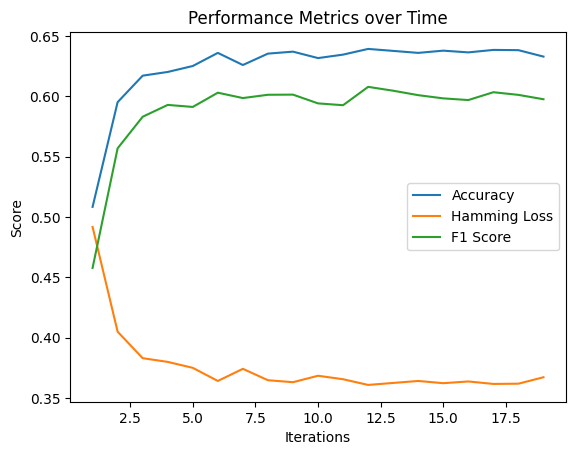

In [35]:
iterations = range(1, len(accuracy_scores) + 1)

plt.plot(iterations, accuracy_scores, label='Accuracy')
plt.plot(iterations, hamming_scores, label='Hamming Loss')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()

##### Test with Random for Multilabel

In [ ]:
hamming_loss_scores = []
jaccard_scores = []
f1_scores = []
for iteration in range(iterations):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    hamming_loss_scores.append(hamming_loss(y_test, y_pred))
    jaccard_scores.append(jaccard_score(y_test, y_pred, average='samples'))
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    print(f"Iteration {iteration + 1}: Loss = {hamming_loss(y_test, y_pred):.4f}, Jaccard_Score = {jaccard_score(y_test, y_pred, average='samples')}, F1 = {f1_score(y_test, y_pred, average='micro')} ")
    sample_size = min(sample_size, len(X_pool))
    selected_indices = np.random.choice(len(X_pool), size=sample_size, replace=False)
    X_sample = X_pool[selected_indices]
    y_sample = y_pool[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.vstack([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)

y_pred = clf.predict(X_test)
print(f"Final Scores: Loss = {hamming_loss(y_test, y_pred):.4f}, Jaccard_Score = {jaccard_score(y_test, y_pred, average='samples')}, F1 = {f1_score(y_test, y_pred, average='micro')} ")

Iteration 1: Loss = 0.0711, Jaccard_Score = 0.26350235099758545, F1 = 0.3354502672819482 
Iteration 2: Loss = 0.0722, Jaccard_Score = 0.26002668699961873, F1 = 0.32621979024167813 
Iteration 3: Loss = 0.0731, Jaccard_Score = 0.2551340704028466, F1 = 0.3203671725892938 
Iteration 4: Loss = 0.0736, Jaccard_Score = 0.25114584657093236, F1 = 0.31502798125483417 
Iteration 5: Loss = 0.0740, Jaccard_Score = 0.24725293345194221, F1 = 0.31135164635255597 
Iteration 6: Loss = 0.0742, Jaccard_Score = 0.25038971491506756, F1 = 0.3135482121061435 
Iteration 7: Loss = 0.0744, Jaccard_Score = 0.2519252764010675, F1 = 0.31446597566471385 
Iteration 8: Loss = 0.0748, Jaccard_Score = 0.24804930740881942, F1 = 0.3101941528897698 
Iteration 9: Loss = 0.0749, Jaccard_Score = 0.24914008556784004, F1 = 0.3118154067157479 
Iteration 10: Loss = 0.0753, Jaccard_Score = 0.24637607489304017, F1 = 0.30770613345315656 


ValueError: Found input variables with inconsistent numbers of samples: [78843, 7869]

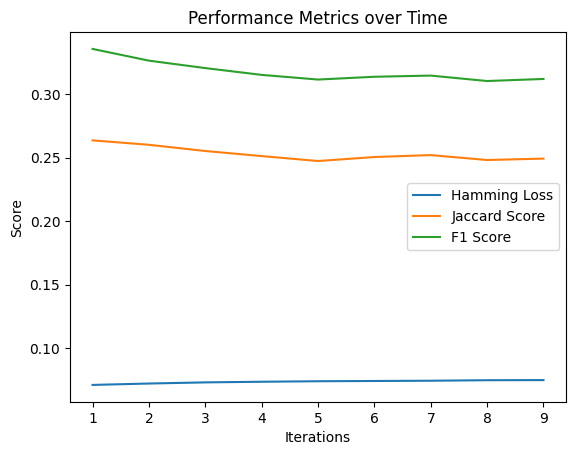

In [ ]:
import matplotlib.pyplot as plt
iterations = range(1, len(hamming_loss_scores) + 1)

plt.plot(iterations, hamming_loss_scores, label='Hamming Loss')
plt.plot(iterations, jaccard_scores, label='Jaccard Score')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()